# Visualization Tutorial

This notebook walks through the process of subclassing [`ChartPlot`](https://helipad.dev/functions/chartplot/) to create a new type of plot that we can use in a panel of the [`Charts`](https://helipad.dev/functions/charts/) visualizer. `ChartPlot` allows any model data to be represented by anything that can be done on a Matplotlib canvas, so we'll be dealing with the Matplotlib API in addition to the Helipad API. In this case, we'll be creating a spatial model and replacing the default spatial visualizer with a 3D bar chart.

## A Basic Model

First, our basic model setup. We instantiate the `helipad` object and set a few options. Importantly, we initialize a spatial network with [`heli.spatial()`](https://helipad.dev/functions/model/spatial/). In this case we have a 20&times;20 grid with half-weighted diagonal connections and wrapping across the edges.

However, `heli.spatial()` also registers the `Charts` visualizer and adds a `spatial` plot named `map` to it. We want to keep the `Charts` visualizer. However, we also want to replace the stock `spatial` plot with our own 3D map. Since `heli.spatial()` returns the map plot object, we can simply call `.remove()` on it, leaving us with an empty `Charts` visualizer.

In [ ]:
from helipad import Helipad
heli = Helipad()

heli.name = '3D Spatial Visualizer'
heli.order = 'random'

mapPlot = heli.spatial(x=20, diag=False, wrap=True)
mapPlot.remove()

From here we can get to the meat of the model. Each period, agents are going to be able to move to an adjacent cell. They choose which cell to move to based on an attractor that grows at a diminishing rate with local population, and a repulsor that grows linearly with population. Thus, we get urban areas with outlying suburbs, depending on how strong the attractor and repulsor are relative to one another.

First, we'll create parameters to weight the attractor and the repulsor, and then functions to calculate them for each patch. The attractor is the population on the patch, plus half the population of its direct neighbors and a quarter of the population of its diagonal neighbors, square rooted and multiplied by the attractor weight. The repulsor is simply the local population times the repulsor weight. The `netAttractor()` property returns the difference between the two.

In [ ]:
from helipad.spatial import Patch
from math import sqrt
import numpy as np

heli.addParameter('attract', 'Attractor weight: 2^', 'slider', 3, opts={'low': -4, 'high': 4, 'step': 1})
heli.addParameter('repulse', 'Repulsor weight: 2^', 'slider', 1, opts={'low': -4, 'high': 4, 'step': 1})
heli.params['num_agent'].opts = {'low': 50, 'high': 1000, 'step': 50}
heli.param('num_agent', 250)

def netAttraction(self):
    pop = len(list(self.agentsOn))
    attr = pop
    
    #Use .outbound('space') instead of .neighbors so we can get the weights
    for e in self.neighbors: #outbound('space', True):
        attr += 0.5 * len(list(e.agentsOn))
    return heli.param('attract') * sqrt(attr) - heli.param('repulse') * pop

Patch.netAttraction = property(netAttraction)

Now we'll program agent behavior. The agent searches neighboring patches, including the current one, for the maximum difference between the attractor and repulsor, and then moves to that patch.

In [ ]:
@heli.hook
def agentStep(agent, model, stage):
    potential = agent.patch.neighbors + [agent.patch]
    vals = [(p, p.netAttraction) for p in potential]
    mx = max([v[1] for v in vals])
    for v in vals:
        if v[1]==mx:
            patch = v[0]
            break
    agent.moveTo(patch.x, patch.y)

## The Visualizer

In order to visualize the population on each patch, we'll use Matplotlib's [`bar3d`](https://matplotlib.org/mpl_toolkits/mplot3d/api.html#mpl_toolkits.mplot3d.axes3d.Axes3D.bar3d) function. `ChartPlot` requires us to specify three methods: `launch(axes)`, `update(data,t)`, and `draw(t)`. We'll write these functions one at a time and then compile them into the class at the end so we can intersperse exposition, but more usually you'll just put all of these methods underneath the class definition.

In [ ]:
from helipad.visualize import ChartPlot
class spatial3D(ChartPlot):
    type = 'spatial3d'
    projection = '3d'

    def launch(self, axes):
        self.heights = {}
        super().launch(axes)
        self.update(self.viz.model.data.all, 0)
        self.draw(0)
 
    def update(self, data, t):
        Z = np.array([list(range(self.viz.model.param('x'))) for i in list(range(self.viz.model.param('y')))])
        
        for x,col in enumerate(self.viz.model.patches):
            for y,a in enumerate(col):
                Z[x][y] = len(list(a.agentsOn))
        
        self.heights[t] = Z.ravel()
        
    def draw(self, t):
        X, Y = np.meshgrid(range(self.viz.model.param('x')), range(self.viz.model.param('y')))
        X, Y = X.ravel(), Y.ravel()
        base = np.zeros_like(Y) # Z coordinates of each bar
        dim = np.array([1 for i in X]) #Length & width of each bar
        self.axes.clear()
        self.axes.bar3d(X, Y, base, dim, dim, self.heights[t], shade=True)

The first method is `launch()`, which sets up our axes before drawing data. The `launch` method receives the Matplotlib `SubplotAxes` object created by `Charts`. The first thing we want to do is to call the parent method. After that, we can use this method to do anything we need to. In this case we'll be telling Matplotlib to create a 3D bar chart, and then feeding it our initial data.

For some plot types, we will be able to update the plot data without redrawing it entirely. In this case, we would draw the plot in `launch()` and update it in `draw()`. Matplotlib's `bar3d` is not one of these, unfortunately. Since we have to redraw the plot each time, we can use a minimal `launch()` method and put all of our drawing code in `draw()`. Here, all we need to do is set aside a variable to store height data which we can scrub back over later.

We populate `self.heights` in the `update()` method, using the model time as the dict index. Note that since the data we need is not reported in a reporter, and thus not passed to the function in the `data` argument, we can retrieve the model object directly using `self.viz.model`. Since the `X` and `Y` coordinates of all the bars stays the same, the only thing we need to store is the `Z` height.

As mentioned earlier, Matplotlib's `axes3d` class does not provide an easy way to update chart data without redrawing it, so we must recreate the chart on each update, using the `Z` data that we stored above in `update()`.

The Matplotlib [`bar3d` method](https://matplotlib.org/mpl_toolkits/mplot3d/api.html#mpl_toolkits.mplot3d.axes3d.Axes3D.bar3d) requires a rather particular array structure. The code above is adapted from the [3D bar chart demo](https://matplotlib.org/3.3.3/gallery/mplot3d/3d_bars.html).

Finally, we register the class using [`Charts.addPlotType()`](https://helipad.dev/functions/charts/addplottype/). Having registered the plot type, we can then add it to our visualization with [`Charts.addPlot()`](https://helipad.dev/functions/charts/addplot/), referring back to it with our class' `type` property.

In [ ]:
heli.visual.addPlotType(spatial3D)
heli.visual.addPlot('map', '3D Population Map', 'spatial3d')

## Run the Model

First the control panel:

In [ ]:
heli.launchCpanel()

And then the visualizations.


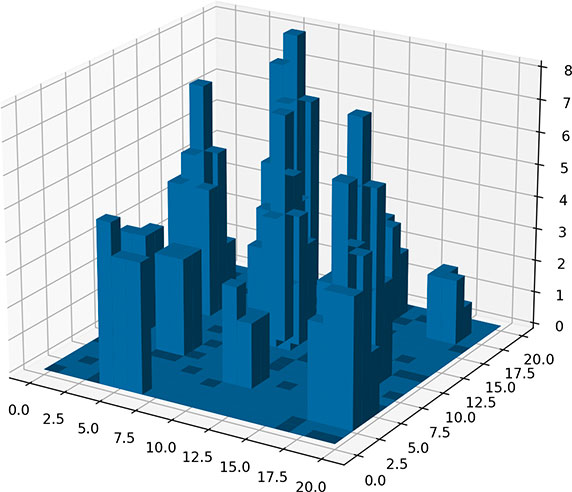

In [15]:
heli.launchVisual()

As you can see from the results, we get just a handful of major cities, surrounded by slightly smaller outlying suburbs, but largely concentrated after just a couple hundred periods.

Though the model is somewhat slow in a Jupyter notebook, note that you can

* Rotate the box to a desired angle
* Scrub over the model time with the time bar, to replay the model

Further exercises:

* Set the patch color to reflect some other property of the patch
* Add other plots alongside our new 3D plot